In [214]:
import matplotlib.pyplot as plt
import scipy.signal as sd
from scipy import misc
import numpy as np
from PIL import Image
import time


class Camera(object):
    """
    Camera class
    """

    def __init__(self, filename, file_format='raw', dtype='<u1',
                 dimension=(2448, 3264), bayer='BGGR', sensor='IMX363'):
        self.filename = filename
        self.file_format = file_format
        self.dtype = dtype
        self.dimension = dimension
        self.bayer = bayer
        self.sensor = sensor
        # self.image = np.zeros(self.dimension)

    def __str__(self):
        return "%s  %r" % (self.__class__, self.__dict__)

    @property
    def raw_reader(self):
        if self.file_format == 'raw':
            temp = np.fromfile(self.filename, self.dtype)
            if self.sensor == 'IMX363':
                NewImage =  np.zeros(self.dimension)
                TenBitsImage = (np.reshape(temp, (self.dimension[0],int(self.dimension[1]*1.25))))
                first2  = (TenBitsImage[:, 4::5]&3)
                second2 = (TenBitsImage[:, 4::5]>>2)&3
                third2  = (TenBitsImage[:, 4::5]>>4)&3
                four2   = (TenBitsImage[:, 4::5]>>6)&3
                NewImage[:, 0::4] = TenBitsImage[:, 0::5]<<2 + first2;
                NewImage[:, 1::4] = TenBitsImage[:, 1::5]<<2 + second2;
                NewImage[:, 2::4] = TenBitsImage[:, 2::5]<<2 + third2;
                NewImage[:, 3::4] = TenBitsImage[:, 3::5]<<2 + four2;
                return NewImage
        else:
            return Image.open(self.filename)

    def awb(self, image):
        """
        Perform global auto white balance (AWB)
        :type image: object
        :param : bayer image
        """
        # create same dimension image
        (width, height) = self.dimension
        new_img = np.zeros(self.dimension)

        # calculate mean of quad images
        mean_channel1 = np.mean(image[0:width:2, 0:height:2])
        mean_channel2 = np.mean(image[0:width:2, 1:height:2])
        mean_channel3 = np.mean(image[1:width:2, 0:height:2])
        mean_channel4 = np.mean(image[1:width:2, 1:height:2])
        # calculate gain for quad images
        max_gain = np.max([mean_channel1, mean_channel2,
                           mean_channel3, mean_channel4])
        channel_gain = max_gain / np.array([mean_channel1, mean_channel2,
                                            mean_channel3, mean_channel4])
        print channel_gain
        # apply gain on quad images
        new_img[0:width:2, 0:height:2] = np.uint16(image[0:width:2, 0:height:2] * channel_gain[0])
        new_img[0:width:2, 1:height:2] = np.uint16(image[0:width:2, 1:height:2] * channel_gain[1])
        new_img[1:width:2, 0:height:2] = np.uint16(image[1:width:2, 0:height:2] * channel_gain[2])
        new_img[1:width:2, 1:height:2] = np.uint16(image[1:width:2, 1:height:2] * channel_gain[3])
        return new_img

    def demosaic(self, image):
        (width, height) = self.dimension
        # quad 1
        mask = np.zeros(self.dimension)
        mask[0:width:2, 0:height:2] = 1
        quad1 = image*mask
        # quad 2
        mask = np.zeros(self.dimension)
        mask[0:width:2, 1:height:2] = 1
        quad2 = image*mask
        # quad 3
        mask = np.zeros(self.dimension)
        mask[1:width:2, 0:height:2] = 1
        quad3 = image*mask
        # quad 4
        mask = np.zeros(self.dimension)
        mask[1:width:2, 1:height:2] = 1
        quad4 = image*mask
        # convolution kernel
        non_green_kernel = np.array([[0.25, 0.5, 0.25], [0.5, 1, 0.5], [0.25, 0.5, 0.25]])
        green_kernel = np.array([[0, 0.25, 0], [0.25, 1.0, 0.25], [0, 0.25, 0]])
        output = np.zeros((width, height, 3))
        if self.bayer == 'RGGB':
            red = quad1
            red = sd.convolve2d(red, non_green_kernel, boundary='wrap', mode='same')
            green = quad2+quad3
            green = sd.convolve2d(green, green_kernel, boundary='wrap', mode='same')
            blue = quad4
            blue = sd.convolve2d(blue, non_green_kernel, boundary='wrap', mode='same')
            output[:, :, 0] = np.uint8(red)
            output[:, :, 1] = np.uint8(green)
            output[:, :, 2] = np.uint8(blue)
            # return output

        if self.bayer == 'BGGR':
            red = quad4
            red = sd.convolve2d(red, non_green_kernel, boundary='wrap', mode='same')
            green = quad2+quad3
            green = sd.convolve2d(green, green_kernel, boundary='wrap', mode='same')
            blue = quad1
            blue = sd.convolve2d(blue, non_green_kernel, boundary='wrap', mode='same')
            output[:, :, 0] = np.uint8(red)
            output[:, :, 1] = np.uint8(green)
            output[:, :, 2] = np.uint8(blue)
            # return output

        if self.bayer == 'GBRG':
            red = quad3
            red = sd.convolve2d(red, non_green_kernel, boundary='wrap', mode='same')
            green = (quad1+quad4)
            green = sd.convolve2d(green, green_kernel, boundary='wrap', mode='same')
            blue = quad2
            blue = sd.convolve2d(blue, non_green_kernel, boundary='wrap', mode='same')
            output[:, :, 0] = np.uint8(red)
            output[:, :, 1] = np.uint8(green)
            output[:, :, 2] = np.uint8(blue)
            # return output

        if self.bayer == 'GRBG':
            red = quad2
            red = sd.convolve2d(red, non_green_kernel, boundary='wrap', mode='same')
            green = (quad1+quad4)
            green = sd.convolve2d(green, green_kernel, boundary='wrap', mode='same')
            blue = quad3
            blue = sd.convolve2d(blue, non_green_kernel, boundary='wrap', mode='same')
            output[:, :, 0] = np.uint8(red)
            output[:, :, 1] = np.uint8(green)
            output[:, :, 2] = np.uint8(blue)
        return output

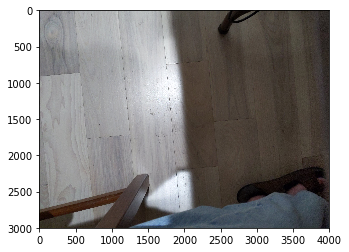

In [104]:
filename = r'c:/Users/fanchang/Downloads/Camera_0.jpg'
image = Image.open(filename)
# plt.figure(figsize=[16, 12])
plt.imshow(image)

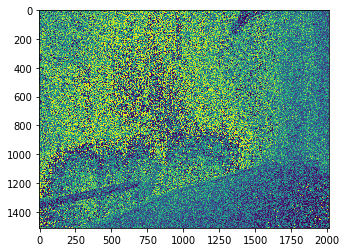

In [215]:
filename2 = r'c:/Users/fanchang/Downloads/Camera_0.raw'
file_format='raw'
dtype = '<u1'
dimension = (3024, 4032)
bayer = 'RGGB'
sensor = 'IMX363'
SN1 = Camera(filename2, file_format, dtype, dimension, bayer, sensor)
img1=SN1.raw_reader
plt.imshow(img1[0::2, 0::2])
# plt.imshow(SN1.demosaic(img1))

In [213]:
newimage=SN1.awb(img1)
# print np.max(np.max(newimage))
# print np.max(np.max(img1))

[1.02611656 1.00069755 1.         1.04607396]


In [220]:
np.max(img1[0::2, 0::2], 1)

array([248., 248., 248., ..., 248., 248., 248.])

In [221]:
img1[0,0::2]

array([ 88.,  32., 208., ...,  72.,  32.,  48.])

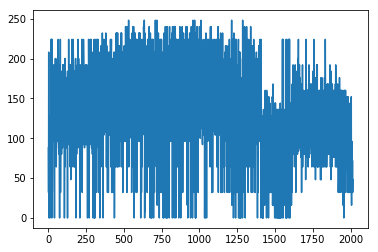

In [224]:
plt.plot(img1[0,0::2])

In [227]:
import cv2
cv2.imwrite('/Users/fanchang/Downloads/test.png', img1[0::2, 0::2])

True